In [ ]:
# !sudo apt-get install python3.7
# !sudo apt-get update -y
# !sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
# !sudo update-alternatives --config python3

In [1]:
"""
maximum availible volume to pool into
"""
max_volume=500

"""
maximum availible volume to be taken out of well
"""
max_oligo_volume=80

"""
maximum availible volume to be taken out of well
"""
min_oligo_volume=4

# """
# target moles of oligo pmol
# """
# target_quantity=90

In [2]:
!pip install numpy
!pip install pyopenms
!pip install biopython
!pip install openpyxl

In [105]:
import re

EXPERIMENT_NAME = "OVFF368"
# reading file
file1 = open(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}.txt', 'r')
oligo_list = [line for line in file1.readlines() if re.search("^[a-zA-Z][1-9]", line)]
import csv

header = ['where\tcode\tseq\tDMT\tcomment\tlength\t']
data = [row.strip() for row in oligo_list]


with open(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_oligos.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    # write the header
    writer.writerow(header)

    writer = csv.writer(f, quotechar='\"', delimiter='\n', quoting=csv.QUOTE_NONE, escapechar='\\')
    # write the data
    writer.writerow(data)

In [106]:
import pandas as pd

df = pd.read_csv(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_oligos.csv', delimiter='\t')
# drop NaN seq
df = df[df['seq'].notna()]
oligo_list = df['seq'].to_list()

In [107]:
from Bio.Seq import Seq
from Bio.SeqUtils import molecular_weight

# Bio.SeqUtils.molecular_weight(seq, seq_type='DNA', double_stranded=False, circular=False, monoisotopic=False)

from pyopenms import *

mass_list=[]
# https://biopython.org/docs/1.75/api/Bio.SeqUtils.html
for oligo_seq in oligo_list: 
    try:
        my_dna = Seq(oligo_seq)
    except:
        print(oligo_seq)
    try:
        print(f"{oligo_seq.strip()}\t" + "%0.2f" % (molecular_weight(my_dna)-79.97))
        mass_list+=["%0.2f" % (molecular_weight(my_dna)-79.97)]
    except ValueError:
        print(f"{oligo_seq.strip()}\t" + "'N' is not a valid unambiguous letter for DNA")
        mass_list+=["NaN"]
    
df['monoisotopic_mass']=mass_list
export_dataframe=df[['where', 'code', 'length', 'seq', 'monoisotopic_mass']]
export_dataframe.to_csv(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_calculated.csv', sep = '\t', index=False)


CGT CCG GCG TAG AGG ATC GAG ATC TTA ATA CGA CTC GGT ATA GGG GAA TTG	15859.18
TTC TAG AGG GGA ATT GTT ATC CGC TCA CAA TTC CCC TAT ACC GAG TCG TAT TAA	16545.64
TGA GCG GAT AAC AAT TCC CCT CTA GAA ATA ATT TTG TTT AAC TTT AAG AAG GAG	16665.77
TTG GGC GGA CGG AAG CAT GGT ATA TCT CCT TCT TAA AGT TAA ACA AAA TTA T	16064.37
ATA TAC CAT GCT TCC GTC CGC CCA AGC GCC CTC CCT CCT CAA TCC CA	14096.05
CCA GTG CCG CGA AGT CGT CGG TGG GAT TGA GGA GGG AGG GCG C	13471.61
CCG ACG ACT TCG CGG CAC TGG GCA ATA TTG CCT GGC TGT GGA TGA ACT	14800.48
GCC AGT CGC GGT GCA TGG GAG AGT TCA TCC ACA GCC AGG CAA TAT TGC	14818.51
CTC CCA TGC ACC GCG ACT GGC CGG TGC ATC TGC TCG CAC GC	12459.97
GTT GAA TCG GCG CGA GCG TGT TGC GTG CGA GCA GAT GCA CCG	13052.35
AAC ACG CTC GCG CCG ATT CAA CTG GGC CAA TAC ATT CTG CTG CGA TG	14384.24
GCA GTA TGC AAC CGG CAC GTC ATT GCA TCG CAG CAG AAT GTA TTG GCC CA	15379.88
CAA TGA CGT GCC GGT TGC ATA CTG CAG CTG GGC CCT AAT GGA CGC CG	14481.28
CGC CAT GAC ATA GGA GAG TTC GGT GTC GGC GTC CAT 

In [109]:
# reading file with seqs 
df_calculated =  pd.read_csv(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_calculated.csv', delimiter='\t', decimal=".")

# read concentrations file
try: 
    df = pd.read_csv(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_concentrations.csv', delimiter=';', decimal=".")
except FileNotFoundError:
    df = pd.read_excel(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_concentrations.xlsx')

"""
strip the text everywhere on data frame
"""
cols = df.select_dtypes(object).columns
df[cols] = df[cols].apply(lambda x: x.str.strip())
"""
and again
"""
cols = df_calculated.select_dtypes(object).columns
df_calculated[cols] = df_calculated[cols].apply(lambda x: x.str.strip())

"""
now merge cleaned dataframes
"""
merge = pd.merge(df, df_calculated, on='where', how='inner', suffixes=('', '_drop'))
#Drop the duplicate columns
merge.drop([col for col in merge.columns if 'drop' in col], axis=1, inplace=True)

# reassign
df = merge

In [112]:
df

,where,code,seq,-,--,length,Nucleic Acid(ng/uL),Unnamed: 7,monoisotopic_mass,e260_mM^-1cm^-1
0,J17,18S_F,GGA CAC GGA CAG GAT TGA CAG ATT GAT AG,(DMT ON),KALISH,#= 29,1816.195,NaN,9039.86,301.7
1,K17,18S_R,GGA CAT CTA AGG GCA TCA CAG ACC,(DMT ON),KALISH,#= 24,1269.812,NaN,7355.78,238.6
2,L17,HPRT1_F,CAC TAT GAG CCT ATA GAC TAT CAG TTC CCT TTG G,(DMT ON),KALISH,#= 34,1826.443,NaN,10367.69,321.2
3,M17,HPRT1_R,CCA GGA CAG AAC AAA ACT TCT TAG ATG CTG,(DMT ON),KALISH,#= 30,1261.725,NaN,9207.98,297.3
4,N17,GUSB_F,GAT CTT CAC TCG GCA GAG ACA ACC,(DMT ON),KALISH,#= 24,1365.211,NaN,7306.75,230.2
...,...,...,...,...,...,...,...,...,...,...
66,L21,Sema_SUMO_F0-14,ACC AGC CAC GCG ATA AAC TCT TTC GCC GCC TGG CC...,(DMT ON),Nikiteev,#= 46,2025.560,NaN,13944.96,420.4
67,M21,Sema_SUMO_F0-15,AGT TTA TCG CGT GGC TGG TCC GTG GCC GCG GTT GA...,(DMT ON),Nikiteev,#= 52,2548.469,NaN,16083.28,484.6
68,N21,Sema_SUMO_F0-16,CTT TGT TAG CAG CCG GAT CAA CCG,(DMT ON),Nikiteev,#= 24,1109.949,NaN,7328.75,224.1
69,M24,TDT_F0-F_(B/S),TAT AGG ATC CAG CCC GAG CCC GGT T,(DMT OFF),CUSTOMER,#= 25,1209.780,NaN,7642.94,236.6


In [111]:
import sys
from Bio.Seq import Seq

# calculation of oligo extinction coefficients (mM^–1*cm^–1);
def e260_func(sequence):
    Coefficients = {
        "a": 15.4,
        "c": 7.4,
        "g": 11.5,
        "t": 8.7,
        "aa": 13.7,
        "ac": 10.6,
        "ag": 12.5,
        "at": 11.4,
        "ca": 10.6,
        "cc": 7.3,
        "cg": 9,
        "ct": 7.6,
        "ga": 12.6,
        "gc": 8.8,
        "gg": 10.8,
        "gt": 10,
        "ta": 11.7,
        "tc": 8.1,
        "tg": 9.5,
        "tt": 8.4,
    }
    
    Coefficients =  {key.upper(): val for key, val in Coefficients.items()}
    e260 = 0
    sequence = Seq(sequence.replace(" ", ""))
    
    for i in range(0, len(sequence) - 1):
        e260 = e260 + 2 * Coefficients[sequence[i] + sequence[i + 1]]
    for i in range(0, len(sequence) - 2):
        e260 = e260 - Coefficients[sequence[i + 1]]
    return e260

# CHANGE THIS LATER
Yield = 100

df["e260_mM^-1cm^-1"] = df["seq"].map(e260_func)
df["corrected_molar_concentration_pmol/mkl"] = (1000*2*df["A260"] / (df["e260_mM^-1cm^-1"] * (1 + (100/ Yield)))) ## (mmol/L == nmol/mkl)
df["corrected_weght_concentration"]=df["corrected_molar_concentration_pmol/mkl"]*df["monoisotopic_mass"]/1000 ## ng/mkl
df["corrected_Nucleic_Acid_Factor"]=(2/(df["e260_mM^-1cm^-1"] * (1 + (100/ Yield))))*df["monoisotopic_mass"]

df = df.round(2)

# write final merged result
df.to_csv(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_merged_input.csv', encoding='UTF8')

KeyError: 'A260'

In [120]:

def detect_pool_name(a, b):

    common_prefix = ''

    for x,y in zip(a, b):
        if x == y:
            common_prefix += x
        else:
            break
    common_prefix = common_prefix.strip("1234567890")
    
    regex_special_chars = "[]\.^$*+?{}|()"
    common_prefix_for_regex = common_prefix
    
    for charachter in regex_special_chars:
        # replace() "returns" an altered string
        replace_with = f"\\{charachter}"
        common_prefix_for_regex = common_prefix_for_regex.replace(charachter, replace_with)

    if re.findall(f'{common_prefix_for_regex}\d+$', b):
        return common_prefix
    
    
def detect_pool_names(df):
    possible_pool_names = []
    for index in range(len(df["code"])-1):
        a = df["code"][index]
        b = df["code"][index+1]
        
        pool_name = detect_pool_name(a, b)
        if (pool_name not in possible_pool_names) & (pool_name!=None):        
            possible_pool_names+=[pool_name]
    return possible_pool_names
    
possible_pool_names = detect_pool_names(df)


In [121]:
possible_pool_names



['Sema_ver2_F0-', 'Sema_SUMO_F0-']

In [ ]:
for i in df.columns:
    try:
        df[i] = df[i].str.replace(',', '.').astype(float)
    except:
        pass
    
df['monoisotopic_mass'] = df['monoisotopic_mass'].astype(float)
df["pM/mkl"] = 1000*df['Nucleic Acid(ng/uL)']/df['monoisotopic_mass']
# df=df.dropna()

"""
ATTENTION!!! HERE YOU CAN CHANGE POOL NAME!!!
"""

pool_1 = "SUMO_F0-"

POOL_NAME=pool_1

df = df[df["code"].str.contains(f'{POOL_NAME}\d+')]
df = df.loc[0:53]

df

In [ ]:
"""
смотрим распределение по корзинам
"""
ax = df['corrected_molar_concentration_pmol/mkl'].plot.hist(bins=12, alpha=0.5)
initial_oligos_concentrations = df['corrected_molar_concentration_pmol/mkl']
ax.set_xlabel("pmol/mkl")
ax.set_ylabel("occurencies")

In [ ]:
'''
определяем выбросы
'''
import pandas
import numpy as np
from scipy import stats

# %reload_ext google.colab.data_table

df['score'] = np.abs(stats.zscore(df['corrected_molar_concentration_pmol/mkl']))<1.8
# df[(np.abs(stats.zscore(df)) < 1.5).all(axis=1)]
filtered, filtered_off = (df[(np.abs(stats.zscore(df['corrected_molar_concentration_pmol/mkl'])) < 1.8)], df[(np.abs(stats.zscore(df['corrected_molar_concentration_pmol/mkl'])) >= 1.8)])
filtered_off

In [ ]:
"""
смотрим распределение по корзинам
"""
ax = filtered['corrected_molar_concentration_pmol/mkl'].plot.hist(bins=12, alpha=0.5)
ax.set_xlabel("pmol/mkl")
ax.set_ylabel("occurencies")

In [ ]:
"""
split into N bins by quantiles
"""
N = 8

labels=list(np.arange(1, N))
labels = [str(elem) for elem in labels]
q = list(np.linspace(0, 1, N))

filtered["quantile"] = pd.qcut(df['corrected_molar_concentration_pmol/mkl'], q=q, labels=labels)

'''
выравниваем группы концентраций в пределах отличия в 1.5 раз
'''
highest_quantile_median_conc = filtered[filtered['quantile'] == labels[-1]]['corrected_molar_concentration_pmol/mkl'].median()
for i in labels:
    
    i_quantile_median_conc = filtered[filtered['quantile'] == i]['corrected_molar_concentration_pmol/mkl'].median()
    mkl = round(5*highest_quantile_median_conc/i_quantile_median_conc)
    filtered.loc[filtered['quantile'] == i, ['mkl']] = mkl


"""
пересчитываем моли
"""
filtered['pmol'] = filtered['mkl']*filtered['corrected_molar_concentration_pmol/mkl']
median_conc = round(filtered['corrected_molar_concentration_pmol/mkl'].median())
median_moles_in_pool = round(filtered['pmol'].median())
# print(filtered.sort_values('pM/mkl'))
print(f"equalized result: median_moles_in_pool = {median_moles_in_pool}")
filtered

In [ ]:
filtered_off['mkl'] = median_moles_in_pool/filtered_off['corrected_molar_concentration_pmol/mkl']
filtered_off.loc[filtered_off['mkl'] >= max_oligo_volume, ['mkl']] = max_oligo_volume
filtered_off.loc[filtered_off['mkl'] <= min_oligo_volume, ['mkl']] = min_oligo_volume
filtered_off['mkl'] = round(filtered_off['mkl'])
filtered_off

In [ ]:
"""
FINAL CONCATENATION AND VOLUME ASSERTION TEST
"""
result = pd.concat([filtered_off, filtered])
result['pmol'] = result['mkl']*result['corrected_molar_concentration_pmol/mkl']
total = result['mkl'].sum()
result['final conc, pmol/mkl'] = round(result['pmol']/total, 2)
print(f"calculated total volume of pool: {total} mkl")
# assert total < total_volume, "max volume exceeded"

'''
если пул больше max_volume (500 мкл) - разбиваем на столько пробирок, сколько потребуется
'''
pool_index_list = []
summ = 0
for i in result['mkl']:
  summ+=i
  pool_index_list+=[round(1+summ//max_volume)]

result['target_well'] = pool_index_list

'''
проверяем, что у нас нет разницы концентраций на порядок
'''
assert min(result['final conc, pmol/mkl'])*10 > max(result['final conc, pmol/mkl']), "разброс концентраций превышает 1 порядок!!!\nЭто непорядок!!!"
"""
если все хорошо - идем дальше
"""
result.sort_index(inplace=True)
result
print(f"разбито на {max(pool_index_list)} пробирки(ок)")

In [ ]:
"""
FINALWORKLIST EXPORT
"""
volume_list = round(result['mkl'], 0).astype(int)
number_of_wells = len(volume_list)

def coordinate_to_number_parser(list_of_coords):
    '''
    переводит координату на плашке из формата A1 в порядковый номер
    '''
    index_list = []
    for i in list_of_coords: 
        
        row = ord(i[0]) - 64
        column = int(i[1:])
        index_list += [16*(column-1)+row]
    
    return index_list

list_of_indexes = coordinate_to_number_parser(result["where"].to_list())

col1 = ["384well"]*number_of_wells
col2 = list_of_indexes
col3 = ["96well"]*number_of_wells
col4 = pool_index_list
col5 = volume_list.to_list()

list_of_lists = [col1, col2, col3, col4, col5]

worklist_df = pd.DataFrame(list_of_lists)
worklist_df = worklist_df.reset_index(drop=True)
worklist_df = worklist_df.T

"""
экспортируем новый worklist
"""
worklist_df.to_csv(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_equalized_conc_worklist_{POOL_NAME}.csv', encoding='UTF8', header=None, index=False)


"""
SOME METADATA
"""
final_equalized_oligo_concentration=median_moles_in_pool/worklist_df[4].sum()
total_volume=worklist_df[4].sum()


print(f"final_equalized_oligo_concentration = ~{final_equalized_oligo_concentration:.3f} pmol/mkl")
print(f"total_volume = {total_volume:.1f} mkl")
print(f"minimal taken volume = {min(worklist_df[4]):.2f} mkl")
print(f"max taken volume = {max(worklist_df[4]):.2f} mkl")
print(f"max разброс финальных концентраций = {100*(max(result['final conc, pmol/mkl'])-min(result['final conc, pmol/mkl']))/(result['final conc, pmol/mkl'].mean()):.2f}% или в {2*(max(result['final conc, pmol/mkl'])-min(result['final conc, pmol/mkl']))/(result['final conc, pmol/mkl'].mean()):.2f} раз")
print(f"среднее значение концентраций {result['final conc, pmol/mkl'].mean():.3f}±{result['final conc, pmol/mkl'].std():.3f} pmol/mkl")

result.to_csv(f'./content/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}_result.csv', encoding='UTF8')

In [ ]:
"""
смотрим распределение по корзинам
"""
ax = result['final conc, pmol/mkl'].plot.hist(bins=5, alpha=0.5)
ax.set_xlabel("pmol/mkl")
ax.set_ylabel("occurencies")

In [ ]:
comparison_df = pd.DataFrame([initial_oligos_concentrations, result['final conc, pmol/mkl']]).T
comparison_df["unaligned"] = comparison_df["corrected_molar_concentration_pmol/mkl"]/comparison_df["corrected_molar_concentration_pmol/mkl"].median()
comparison_df["aligned"] = comparison_df['final conc, pmol/mkl']/comparison_df['final conc, pmol/mkl'].median()
comparison_df = comparison_df[["aligned", "unaligned"]]
comparison_df = comparison_df.melt(var_name='groups', value_name='normalized molar concentrations')

import seaborn as sns

ax = sns.violinplot(x = "groups", y="normalized molar concentrations", data=comparison_df, color='r', alpha = 0.1)


# final concentration dependency on yield:
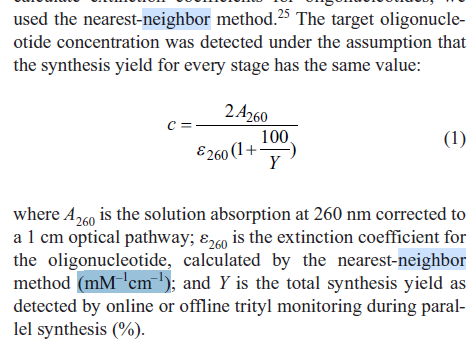
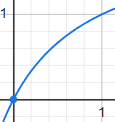

In [ ]:
Сравниваем 4 эксперимента 
 - с выравниванием и без + эти два с очисткой на магнитных частицах
 - Как сравнивать? 
     - смотреть распределение продуктов на капиллярном форезе
     - по интенсивности на форезе при одинаковом количестве циклов 
     - на риалтаймнике
 - Можно ли одновременно на риалтаймнике?
